Notebook que sirve de ejemplo para calcular el baricentro de un conjunto de datos de imágenes.

# Configuraciones iniciales

## Constantes

In [1]:
NOTEBOOK = 3
CLEAN_LOGS = True  # If you want to clean the logs directory
SAVE_FIGS = True  # If you want to save the figures.

REPORT_EVERY = 100  # To report at the logger
PLOT_EVERY = None
MAX_ITER = 5_000  # MAx number of iterations for the SGDW
BATCH_SIZE = 1
PROJ_EVERY = 1

MAX_ITER = 50; REPORT_EVERY = 5  # Descomentar para debuguear

In [2]:
import random

import numpy as np
import torch

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
from pathlib import Path
from icecream import ic


DS_NAME = "data"

CURR_PATH = Path().absolute()
ic(CURR_PATH)
BASE_PATH = CURR_PATH.parent.parent
ic(BASE_PATH)
DATA_PATH = BASE_PATH / "data"
ic(DATA_PATH)
WGAN_PATH = BASE_PATH / "wgan_gp"
ic(WGAN_PATH)
NETS_PATH = WGAN_PATH / "networks" 
ic(NETS_PATH)
IMGS_PATH = CURR_PATH / "imgs" / f"notebook-{NOTEBOOK:02d}"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
ic(IMGS_PATH)

ic| CURR_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw')
ic| BASE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
ic| DATA_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
ic| WGAN_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp')
ic| NETS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
ic| IMGS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-03')


PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-03')

In [4]:
def save_fig(fig_, name_to_save: str) -> None:
    """
    Saves a figure using the name
    """
    if SAVE_FIGS:
        PATH_TO_SAVE = IMGS_PATH / name_to_save
        fig_.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
        fig_.savefig(PATH_TO_SAVE.with_suffix(".png"))

## Importaciones generales

In [5]:
from icecream import ic
from bwb.sgdw import sgdw
from bwb.sgdw import wrappers
from bwb.sgdw import plotters
from bwb.distributions import *

## Configuraciones 

In [6]:
from bwb.config import conf

conf.use_gpu()
conf.use_single_precision()
conf.set_eps(1e-16)
conf

Config(dtype=torch.float32, device=cuda:0, eps=1.00e-16)

## Configuración del Logger

In [7]:
import time
from pathlib import Path


# Create the logs directory
LOG_PATH = Path("logs") / f"notebook-{NOTEBOOK:02d}_{time.strftime('%Y%m%d_%H%M%S')}.log"
if not LOG_PATH.parent.exists():
    LOG_PATH.parent.mkdir()

# Clean the logs
if CLEAN_LOGS:
    for log_file in Path("logs").glob(f"notebook-{NOTEBOOK:02d}*.log"):
        log_file.unlink()

In [8]:
import logging
from bwb.logging_ import log_config


# Remove the handlers
log_config.remove_all_handlers()
ic(log_config.loggers)

# Define and add FileHandler
fh = logging.FileHandler(LOG_PATH)
log_config.FORMATTER = fh
log_config.add_handler(fh)


_log = log_config.get_logger("notebook")
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.sgdw")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.plotters")

ic| log_config.loggers: {'bwb.config': <Logger bwb.config (WARNING)>,
                         'bwb.distributions.discrete_distribution': <Logger bwb.distributions.discrete_distribution (WARNING)>,
                         'bwb.distributions.distribution_samplers': <Logger bwb.distributions.distribution_samplers (WARNING)>,
                         'bwb.distributions.posterior_samplers': <Logger bwb.distributions.posterior_samplers (WARNING)>,
                         'bwb.distributions.utils': <Logger bwb.distributions.utils (WARNING)>,
                         'bwb.pot.transports': <Logger bwb.pot.transports (WARNING)>,
                         'bwb.sgdw.plotters': <Logger bwb.sgdw.plotters (WARNING)>,
                         'bwb.sgdw.sgdw': <Logger bwb.sgdw.sgdw (WARNING)>,
                         'bwb.sgdw.utils': <Logger bwb.sgdw.utils (WARNING)>,
                         'bwb.sgdw.wrappers': <Logger bwb.sgdw.wrappers (WARNING)>,
                         'bwb.utils.autocorr': <

LoggerConfiguration(LEVEL=30, HANDLERS=[<FileHandler /home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/logs/notebook-03_20240522_005440.log (NOTSET)>])

Esta celda es para configurar la información mostrada en el logger

In [9]:
# Set the default options for the report
wrappers.ReportProxy.INCLUDE_OPTIONS = wrappers.ReportOptions(
    dt=False,
    dt_per_iter=True,
    iter=True,
    step_schd=True,
    total_time=True,
    w_dist=False
)

## Obtención del dataset

ic| file_path: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/dataset/cleaned/data.npy')
ic| len(dataset): 195479


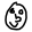

In [10]:
# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset
import quick_torch as qt
import torchvision.transforms.v2 as T

transform_ds = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(conf.dtype, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

def get_ds(file_path: Path, transform=transform_ds) -> ModelDataset:
    """
    Get a dataset to follow the interface
    """
    ic(file_path)
    categories = [qt.Category.FACE]
    dataset_ = qt.QuickDraw(
        root=DATA_PATH,
        categories=categories,
        transform=transform,
        download=True,
        recognized=True,
    )
    path_dataset = Path(file_path)
    dataset_.data = np.load(path_dataset).reshape(-1, 28, 28)
    dataset_.targets = np.ones(len(dataset_.data), dtype=int)
    dataset = dataset_.get_train_data()
    ic(len(dataset))

    return ModelDataset(dataset)

DS_PATH = WGAN_PATH / "dataset" / "cleaned" / f"{DS_NAME}.npy"
ds_models = get_ds(DS_PATH)

ds_models.get(0)

In [11]:
ds_models

ModelDataset(device=cuda:0, dtype=torch.float32, dataset=Dataset QuickDraw
    Number of datapoints: 195479
    Root location: /home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data
    StandardTransform
Transform: Compose(
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           ))

## Obtener GAN

De la misma manera, se puede definir un muestreador de distribuciones utilizando una GAN. Para ello, empezamos definiendo las redes neuronales a utilizar

In [12]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = conf.device

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)


G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"
ic(FACE_PATH)

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

ic| FACE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks/cleaned_data_zDim128_norm_bs_128')


In [13]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cuda:0, dtype=torch.float32, seed=3309388465987489)

torch.float32


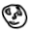

In [14]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(conf.dtype),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(conf.dtype),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])


out: DistributionDraw = transform_out(m)
print(out.dtype)
out

## Definir Proyector

In [15]:
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold
import torchvision.transforms.v2 as T

transform_in_proj = T.Compose([
    # From pdf to grayscale
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(conf.dtype, scale=True),
    T.Normalize(
        [0.5 for _ in range(1)],
        [0.5 for _ in range(1)],
    ),
])

transform_out_proj = T.Compose([
    # Ensure the range is in [0, 1]
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.max(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
    T.Lambda(lambda x: x.squeeze(0)),
])

_proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

def proj(input_: torch.Tensor) -> torch.Tensor:
    """
    Defines a projector using the interface.
    """
    return _proj(input_).to(input_)

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k = 0 $, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor
 inicial.

In [16]:
from bwb.sgdw.utils import step_scheduler
window = 5

def test_gamma(gamma_) -> None:

    for t in range(window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 50
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 100
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 300
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 500
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 1_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 3_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()

    init = 5_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma_(t) = :.2%}")
    print()


_a = 3
_eps = 1e-3
params = dict(a=_a, b=_a+1e-2, c=0.5+_eps)
# params = dict(a=1, b=1, c=1)

gamma = step_scheduler(**params)

test_gamma(step_scheduler(**params))

t = 0; gamma_(t) = 99.67%
t = 1; gamma_(t) = 94.55%
t = 2; gamma_(t) = 90.15%
t = 3; gamma_(t) = 86.31%
t = 4; gamma_(t) = 82.93%

t = 50; gamma_(t) = 38.89%
t = 51; gamma_(t) = 38.57%
t = 52; gamma_(t) = 38.25%
t = 53; gamma_(t) = 37.94%
t = 54; gamma_(t) = 37.63%

t = 100; gamma_(t) = 28.60%
t = 101; gamma_(t) = 28.47%
t = 102; gamma_(t) = 28.34%
t = 103; gamma_(t) = 28.21%
t = 104; gamma_(t) = 28.09%

t = 300; gamma_(t) = 16.97%
t = 301; gamma_(t) = 16.94%
t = 302; gamma_(t) = 16.91%
t = 303; gamma_(t) = 16.89%
t = 304; gamma_(t) = 16.86%

t = 500; gamma_(t) = 13.21%
t = 501; gamma_(t) = 13.20%
t = 502; gamma_(t) = 13.19%
t = 503; gamma_(t) = 13.18%
t = 504; gamma_(t) = 13.16%

t = 1_000; gamma_(t) = 9.38%
t = 1_001; gamma_(t) = 9.37%
t = 1_002; gamma_(t) = 9.37%
t = 1_003; gamma_(t) = 9.37%
t = 1_004; gamma_(t) = 9.36%

t = 3_000; gamma_(t) = 5.43%
t = 3_001; gamma_(t) = 5.42%
t = 3_002; gamma_(t) = 5.42%
t = 3_003; gamma_(t) = 5.42%
t = 3_004; gamma_(t) = 5.42%

t = 5_000; gamma_(

# Baricentro de imágenes

Para obtener el baricentro de un conjunto de imágenes, es necesario utilizar la clase `UniformDiscreteSampler` y fijarla con una clase que tenga los siguientes métodos:
* `get(i) -> Distribution` que retorne la distribución $i$-ésima.
* `__len__() -> int` que retorne el tamaño del dataset.

In [17]:
distr_sampler = UniformDiscreteSampler[DistributionDraw]().fit(models=ds_models)

Luego definimos el algoritmo a utilizar. En este caso, utilizaremos `DebiesedDistributionDrawSGDW` que realiza los transportes utilizando un método convolución debiesed. 

In [18]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=distr_sampler,
    step_scheduler=step_scheduler(**params),
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITER,
)
dist_draw_sgdw = wrappers.ReportProxy(dist_draw_sgdw, report_every=REPORT_EVERY)
dist_draw_sgdw

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=UniformDiscreteSampler(n_models=195479)
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=0, w_dist=∞, t=0:00:00.00, Δt=0.00 [ms])

Definimos una clase para comparar las imágenes de las muestras con la iteración del algoritmo.

In [19]:
plotter_comp = plotter_comp_ds = plotters.PlotterComparisonProjected(
    dist_draw_sgdw,
    projector=proj,
    proj_every=PROJ_EVERY,
    n_cols=12,
    n_rows=2,
    cmap="binary_r",
    plot_every=PLOT_EVERY,
)
plotter_comp.sgdw

- LogPosWgtIterProxy:
    len_register=0

- SGDWProjectedDecorator:
    project_every=1

- LogPosWgtIterProxy:
    len_register=0

- LogPosWgtSampledProxy:
    len_register=0

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=UniformDiscreteSampler(n_models=195479)
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=0, w_dist=∞, t=0:00:00.00, Δt=0.00 [ms])

In [20]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' DS barycenter")
bar = plotter_comp.run()
plotter_comp.sgdw

- LogPosWgtIterProxy:
    len_register=51

- SGDWProjectedDecorator:
    project_every=1

- LogPosWgtIterProxy:
    len_register=51

- LogPosWgtSampledProxy:
    len_register=51

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=UniformDiscreteSampler(n_models=195479)
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=50, w_dist=∞, t=0:00:13.81, Δt=237.78 [ms])

Obtenemos una visualización de las primeras imágenes.

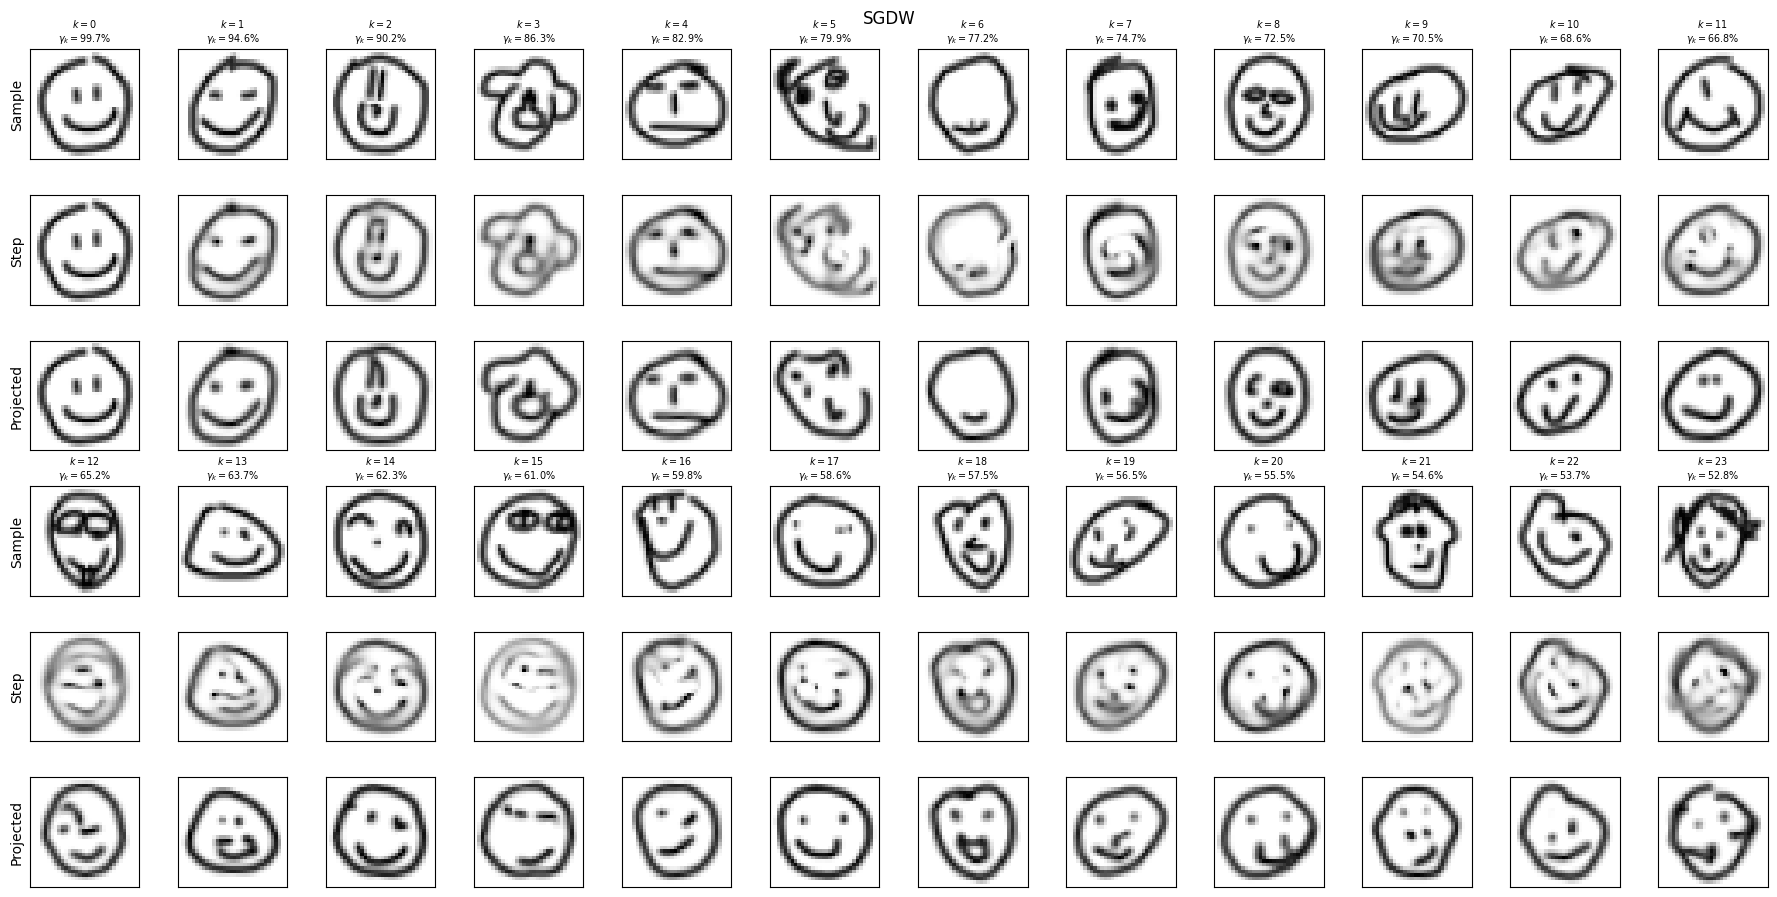

In [21]:
fig, _ = plotter_comp.plot(0)
save_fig(fig, "first-iters-DS")

Obtenemos una visualización de las últimas imágenes.

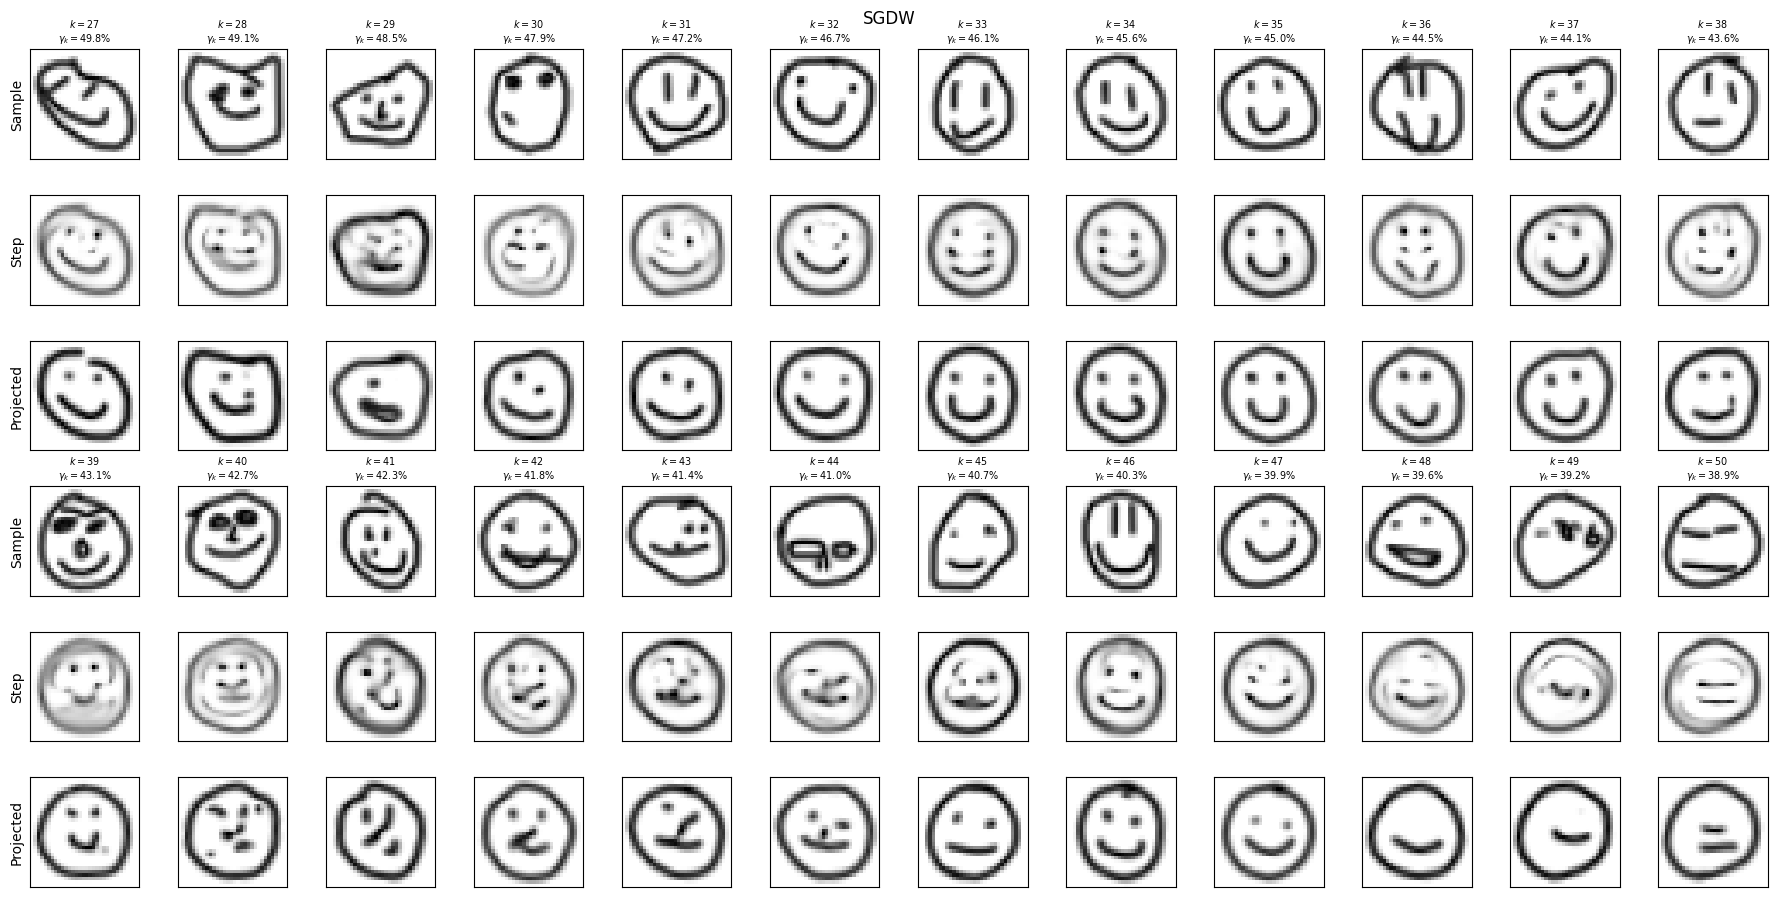

In [22]:
fig, _ = plotter_comp.plot()
save_fig(fig, "last-iters-DS")

# Baricentro de la GAN

## Definir el algoritmo

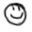

In [23]:
distr_sampler = GeneratorDistribSampler()
distr_sampler.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out_)
distr_sampler.draw()

In [24]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=distr_sampler,
    step_scheduler=step_scheduler(**params),
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITER,
)
dist_draw_sgdw = wrappers.ReportProxy(dist_draw_sgdw, report_every=REPORT_EVERY)
dist_draw_sgdw

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=GeneratorDistribSampler()
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=0, w_dist=∞, t=0:00:00.00, Δt=0.00 [ms])

Definimos una clase para comparar las imágenes de las muestras con la iteración del algoritmo.

In [25]:
plotter_comp = plotters.PlotterComparisonProjected(
    dist_draw_sgdw,
    projector=proj,
    proj_every=PROJ_EVERY,
    n_cols=12,
    n_rows=2,
    cmap="binary_r",
    plot_every=PLOT_EVERY,
)
plotter_comp.sgdw

- LogPosWgtIterProxy:
    len_register=0

- SGDWProjectedDecorator:
    project_every=1

- LogPosWgtIterProxy:
    len_register=0

- LogPosWgtSampledProxy:
    len_register=0

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=GeneratorDistribSampler()
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=0, w_dist=∞, t=0:00:00.00, Δt=0.00 [ms])

### Celda para correr algoritmo

In [26]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' GAN barycenter")
_ = plotter_comp.run()
plotter_comp.sgdw

- LogPosWgtIterProxy:
    len_register=51

- SGDWProjectedDecorator:
    project_every=1

- LogPosWgtIterProxy:
    len_register=51

- LogPosWgtSampledProxy:
    len_register=51

- ReportProxy:
    report_every=5
    level=INFO

- DebiesedDistributionDrawSGDW:
    distr_sampler=GeneratorDistribSampler()
    det_params=DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞)
    iter_params=IterationParameters(k=50, w_dist=∞, t=0:00:13.74, Δt=388.64 [ms])

Obtenemos una visualización de las primeras imágenes.

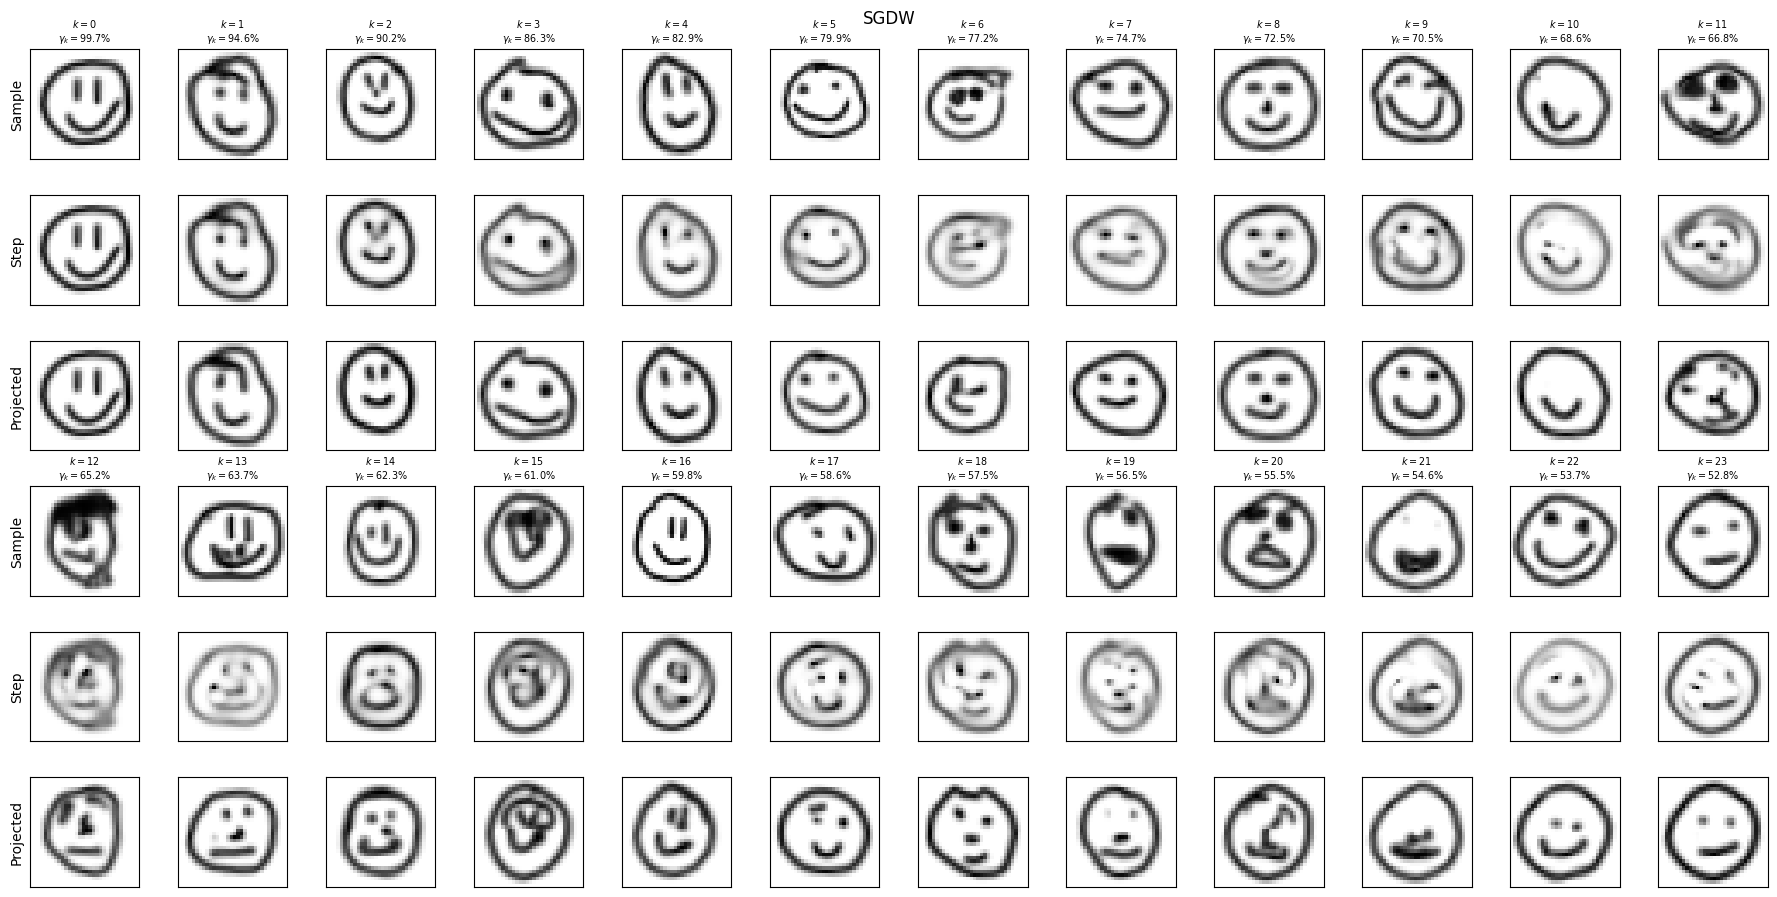

In [27]:
fig, _ = plotter_comp.plot(0)
save_fig(fig, "first-iters-GAN")

Obtenemos una visualización de las últimas imágenes.

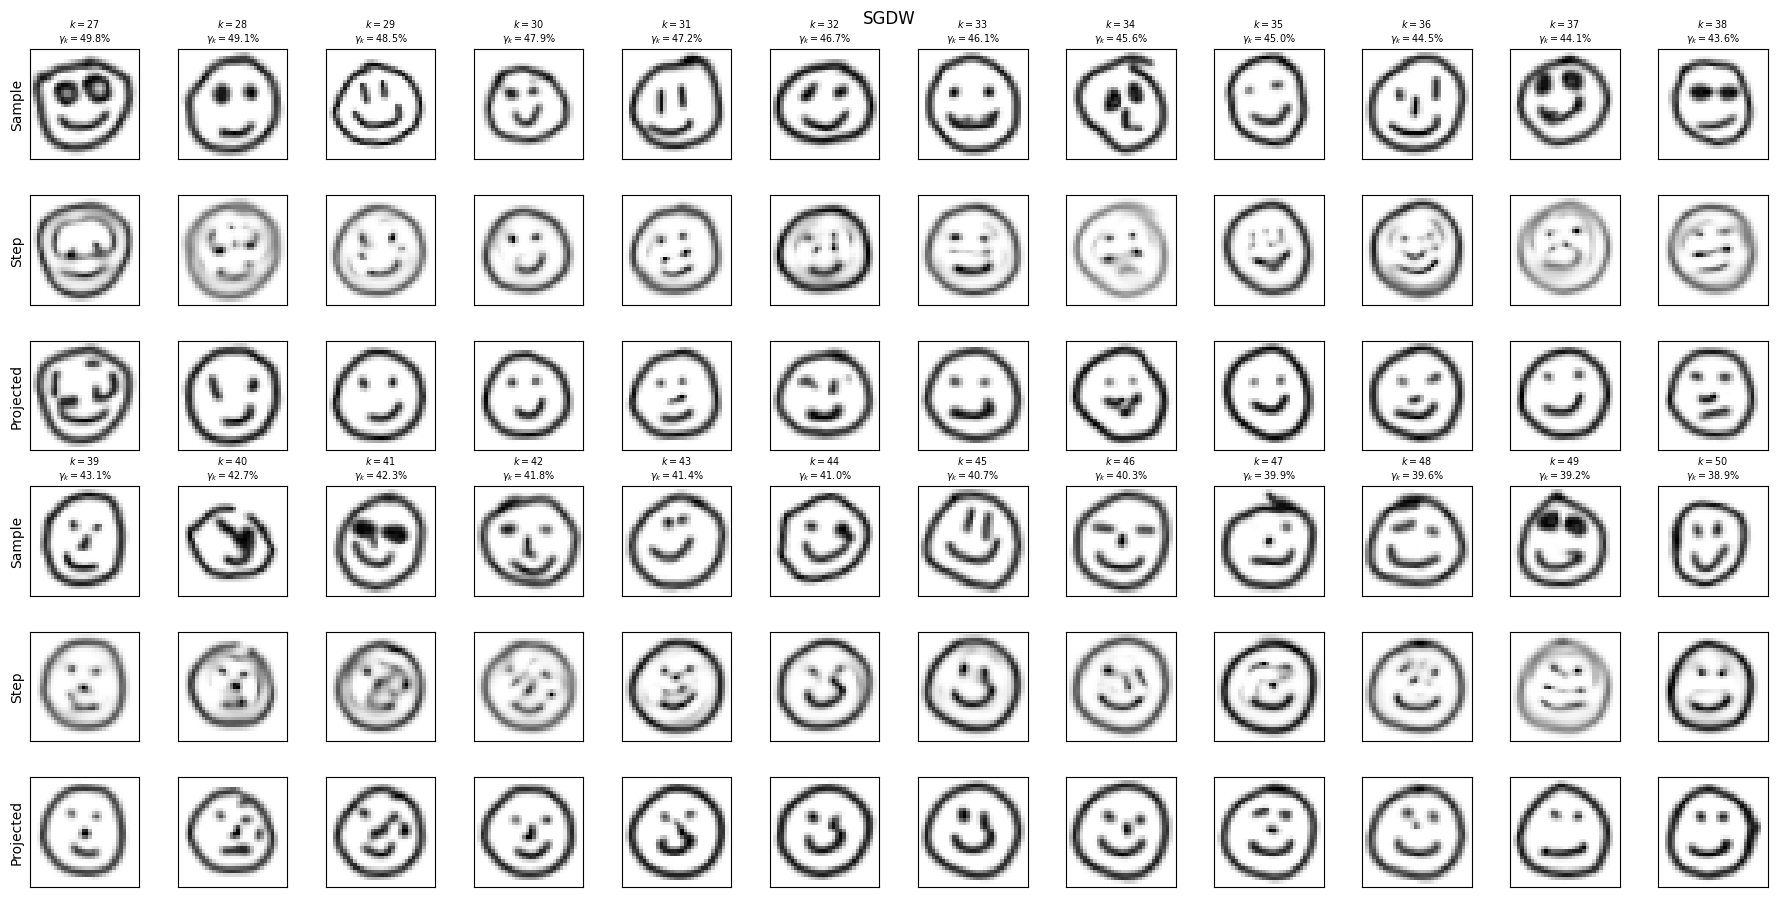

In [28]:
fig, _ = plotter_comp.plot()
save_fig(fig, "last-iters-GAN")